In [1]:

# import builtins
# import inspect

# # Save the original print function
# original_print = builtins.print

# def custom_print(*args, **kwargs):
#     # Get the current frame and the frame that called this function
#     frame = inspect.currentframe()
#     caller_frame = frame.f_back

#     # Get the filename and line number from the caller frame
#     filename = caller_frame.f_globals.get("__file__", "Notebook Cell")
#     lineno = caller_frame.f_lineno

#     # Create the location info string
#     location_info = f"[{filename}:{lineno}]"

#     # Call the original print function with the location info and original args
#     original_print(location_info, *args, **kwargs)

# # Monkey patch the built-in print function
# builtins.print = custom_print



%load_ext autoreload
%autoreload 2
import sys
import torch


sys.path.insert(0,'/home/aw1223/ip/agile')

from sdk.ample import Ample

from torch_geometric.datasets import FakeDataset #TODO remove
from sdk.models.models import MLP_Model,Interaction_Net_Model

from torch_geometric.data import Data


class ToyModel_Lin(torch.nn.Module):
    def __init__(self, in_channels=32, out_channels=32, layer_count=1, hidden_dimension=32, precision = torch.float32):
        super().__init__()
        self.precision = precision
        self.layers = torch.nn.ModuleList()


        self.linear1 = MLP_Model(in_channels, out_channels) 
        self.linear1.name  = 'linear_embedder1'
        self.layers.append(self.linear1) #Used to map weights in SDK


        self.linear2 = MLP_Model(in_channels, out_channels) 
        self.linear2.name  = 'linear_embedder2'
        self.layers.append(self.linear2) #Used to map weights in SDK


        for layer in self.layers:
            layer.to(self.precision)

    def forward(self, x):
        outputs_model = []
        x = x.to(self.precision) 
        outputs_sub_model1,x = self.linear1(x)

        outputs_sub_model2,x = self.linear2(x)


        outputs_model = outputs_sub_model1 + outputs_sub_model2# + outputs_sub_model3#+ outputs_sub_model3 + outputs_sub_model4

        return outputs_model,x


class ToyModel(torch.nn.Module):
    def __init__(self, in_channels=32, out_channels=32, layer_count=1, hidden_dimension=32, precision = torch.float32):
        super().__init__()
        self.precision = precision
        self.layers = torch.nn.ModuleList()

        # self.linear1 = MLP_Model(in_channels, out_channels) 
        # self.linear1.name  = 'linear_embedder1'
        # self.layers.append(self.linear1) #Used to map weights in SDK

        self.int_net = Interaction_Net_Model()
        self.int_net.name  = 'int_net'
        self.layers.append(self.int_net) #Used to map weights in SDK



        for layer in self.layers:
            layer.to(self.precision)


    def forward(self, x,edge_index,edge_attr):
        outputs_model = []
        x = x.to(self.precision) 
        # outputs_sub_model1,x = self.linear1(x)

        outputs_model,x = self.int_net(x, edge_index, edge_attr)

        return outputs_model,x


model = ToyModel_Lin(32,32)

dataset = Data()
dataset.x = torch.tensor([[-2.0775e-01,  5.4138e-01, -9.3228e-01, -1.5647e-02, -9.2422e-01,
         -1.4551e+00,  1.1447e+00,  4.8944e-01, -1.2190e+00, -2.1434e+00,
          8.0335e-01, -1.3588e+00, -1.2911e+00,  1.1237e+00,  1.1250e-01,
          3.9626e-01,  5.1411e-01,  9.9543e-01,  7.6991e-02,  1.1795e+00,
         -1.2423e+00, -2.6467e-01, -4.9839e-01, -1.0298e+00, -2.2073e+00,
          1.7572e+00, -5.1693e-01,  1.4884e+00,  1.1717e+00, -1.6047e+00,
         -1.0268e+00,  1.6982e+00],
        [-1.8529e+00,  1.6048e+00, -6.7576e-01,  4.8206e-01, -7.3550e-01,
          2.7671e+00,  6.5742e-01,  1.1275e-01, -8.2426e-01,  9.4348e-01,
         -5.4252e-01,  1.3881e+00, -3.2231e-01,  2.2466e+00,  2.9660e-01,
         -3.3892e-01, -3.5646e-01,  1.7096e+00,  6.5559e-01,  9.3671e-01,
         -2.0564e-01, -2.5100e-01, -6.0347e-02, -9.6708e-01,  2.2658e+00,
          2.2228e-01, -2.8040e+00, -8.2614e-01,  5.2462e-01, -2.1695e+00,
         -1.4330e-02,  8.4461e-01],
        [ 6.7803e+00,  5.0186e+00,  5.3118e+00,  6.6033e+00,  5.3946e+00,
          4.0241e+00,  5.3939e+00,  5.0030e+00,  4.8918e+00,  3.9511e+00,
          6.0363e+00,  4.9824e+00,  5.2248e+00,  6.5227e+00,  5.0742e+00,
          4.1273e+00,  4.4227e+00,  5.2284e+00,  5.5740e+00,  6.3545e+00,
          4.3107e+00,  5.2994e+00,  5.3288e+00,  5.3148e+00,  5.8875e+00,
          5.0108e+00,  5.8182e+00,  4.4662e+00,  5.2387e+00,  6.0119e+00,
          4.5336e+00,  5.5987e+00]])
dataset.edge_index = torch.tensor([[ 0,  0,  0,  1,  1,  1, 2,  2,  2],
        [ 0,  1, 2,  0,  1,  2,  0,  1, 2]])
dataset.edge_attr =  torch.tensor([[-2.0775e-01,  5.4138e-01, -9.3228e-01, -1.5647e-02, -9.2422e-01,
         -1.4551e+00,  1.1447e+00,  4.8944e-01, -1.2190e+00, -2.1434e+00,
          8.0335e-01, -1.3588e+00, -1.2911e+00,  1.1237e+00,  1.1250e-01,
          3.9626e-01,  5.1411e-01,  9.9543e-01,  7.6991e-02,  1.1795e+00,
         -1.2423e+00, -2.6467e-01, -4.9839e-01, -1.0298e+00, -2.2073e+00,
          1.7572e+00, -5.1693e-01,  1.4884e+00,  1.1717e+00, -1.6047e+00,
         -1.0268e+00,  1.6982e+00],
        [-1.8529e+00,  1.6048e+00, -6.7576e-01,  4.8206e-01, -7.3550e-01,
          2.7671e+00,  6.5742e-01,  1.1275e-01, -8.2426e-01,  9.4348e-01,
         -5.4252e-01,  1.3881e+00, -3.2231e-01,  2.2466e+00,  2.9660e-01,
         -3.3892e-01, -3.5646e-01,  1.7096e+00,  6.5559e-01,  9.3671e-01,
         -2.0564e-01, -2.5100e-01, -6.0347e-02, -9.6708e-01,  2.2658e+00,
          2.2228e-01, -2.8040e+00, -8.2614e-01,  5.2462e-01, -2.1695e+00,
         -1.4330e-02,  8.4461e-01],
        [ 6.7803e+00,  5.0186e+00,  5.3118e+00,  6.6033e+00,  5.3946e+00,
          4.0241e+00,  5.3939e+00,  5.0030e+00,  4.8918e+00,  3.9511e+00,
          6.0363e+00,  4.9824e+00,  5.2248e+00,  6.5227e+00,  5.0742e+00,
          4.1273e+00,  4.4227e+00,  5.2284e+00,  5.5740e+00,  6.3545e+00,
          4.3107e+00,  5.2994e+00,  5.3288e+00,  5.3148e+00,  5.8875e+00,
          5.0108e+00,  5.8182e+00,  4.4662e+00,  5.2387e+00,  6.0119e+00,
          4.5336e+00,  5.5987e+00],
        [-2.0775e-01,  5.4138e-01, -9.3228e-01, -1.5647e-02, -9.2422e-01,
         -1.4551e+00,  1.1447e+00,  4.8944e-01, -1.2190e+00, -2.1434e+00,
          8.0335e-01, -1.3588e+00, -1.2911e+00,  1.1237e+00,  1.1250e-01,
          3.9626e-01,  5.1411e-01,  9.9543e-01,  7.6991e-02,  1.1795e+00,
         -1.2423e+00, -2.6467e-01, -4.9839e-01, -1.0298e+00, -2.2073e+00,
          1.7572e+00, -5.1693e-01,  1.4884e+00,  1.1717e+00, -1.6047e+00,
         -1.0268e+00,  1.6982e+00],
        [-1.8529e+00,  1.6048e+00, -6.7576e-01,  4.8206e-01, -7.3550e-01,
          2.7671e+00,  6.5742e-01,  1.1275e-01, -8.2426e-01,  9.4348e-01,
         -5.4252e-01,  1.3881e+00, -3.2231e-01,  2.2466e+00,  2.9660e-01,
         -3.3892e-01, -3.5646e-01,  1.7096e+00,  6.5559e-01,  9.3671e-01,
         -2.0564e-01, -2.5100e-01, -6.0347e-02, -9.6708e-01,  2.2658e+00,
          2.2228e-01, -2.8040e+00, -8.2614e-01,  5.2462e-01, -2.1695e+00,
         -1.4330e-02,  8.4461e-01],
        [ 6.7803e+00,  5.0186e+00,  5.3118e+00,  6.6033e+00,  5.3946e+00,
          4.0241e+00,  5.3939e+00,  5.0030e+00,  4.8918e+00,  3.9511e+00,
          6.0363e+00,  4.9824e+00,  5.2248e+00,  6.5227e+00,  5.0742e+00,
          4.1273e+00,  4.4227e+00,  5.2284e+00,  5.5740e+00,  6.3545e+00,
          4.3107e+00,  5.2994e+00,  5.3288e+00,  5.3148e+00,  5.8875e+00,
          5.0108e+00,  5.8182e+00,  4.4662e+00,  5.2387e+00,  6.0119e+00,
          4.5336e+00,  5.5987e+00],
          [-2.0775e-01,  5.4138e-01, -9.3228e-01, -1.5647e-02, -9.2422e-01,
         -1.4551e+00,  1.1447e+00,  4.8944e-01, -1.2190e+00, -2.1434e+00,
          8.0335e-01, -1.3588e+00, -1.2911e+00,  1.1237e+00,  1.1250e-01,
          3.9626e-01,  5.1411e-01,  9.9543e-01,  7.6991e-02,  1.1795e+00,
         -1.2423e+00, -2.6467e-01, -4.9839e-01, -1.0298e+00, -2.2073e+00,
          1.7572e+00, -5.1693e-01,  1.4884e+00,  1.1717e+00, -1.6047e+00,
         -1.0268e+00,  1.6982e+00],
        [-1.8529e+00,  1.6048e+00, -6.7576e-01,  4.8206e-01, -7.3550e-01,
          2.7671e+00,  6.5742e-01,  1.1275e-01, -8.2426e-01,  9.4348e-01,
         -5.4252e-01,  1.3881e+00, -3.2231e-01,  2.2466e+00,  2.9660e-01,
         -3.3892e-01, -3.5646e-01,  1.7096e+00,  6.5559e-01,  9.3671e-01,
         -2.0564e-01, -2.5100e-01, -6.0347e-02, -9.6708e-01,  2.2658e+00,
          2.2228e-01, -2.8040e+00, -8.2614e-01,  5.2462e-01, -2.1695e+00,
         -1.4330e-02,  8.4461e-01],
        [ 6.7803e+00,  5.0186e+00,  5.3118e+00,  6.6033e+00,  5.3946e+00,
          4.0241e+00,  5.3939e+00,  5.0030e+00,  4.8918e+00,  3.9511e+00,
          6.0363e+00,  4.9824e+00,  5.2248e+00,  6.5227e+00,  5.0742e+00,
          4.1273e+00,  4.4227e+00,  5.2284e+00,  5.5740e+00,  6.3545e+00,
          4.3107e+00,  5.2994e+00,  5.3288e+00,  5.3148e+00,  5.8875e+00,
          5.0108e+00,  5.8182e+00,  4.4662e+00,  5.2387e+00,  6.0119e+00,
          4.5336e+00,  5.5987e+00]])
# dataset = FakeDataset(
#                         num_graphs=1, 
#                         avg_num_nodes = 15,
#                         avg_degree=3,
#                         num_channels=32,
#                         edge_dim=0
#                     )[0]

inputs = [dataset.x]
# inputs = [dataset.x,dataset.edge_index,dataset.edge_attr]

out = model(*inputs)


/home/aw1223/anaconda3/envs/ample/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Rendering graph...


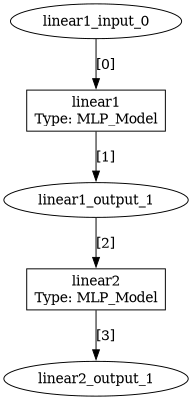

1it [00:00, 7767.23it/s]
1it [00:00, 12865.96it/s]
/home/aw1223/anaconda3/envs/ample/lib/python3.11/site-packages/torch/jit/_trace.py:1088: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  module._c._create_method_from_trace(


In [2]:
import torch.nn.init as init

%load_ext autoreload
%autoreload 2
%pwd
ample = Ample()
ample.sim = True
# Need weights to be initialized before calling to_device

model.to_device('ample',data=inputs) #Change 

In [3]:
out = model(*inputs)


Executing on AMPLE
cd /home/aw1223/ip/agile/hw/sim
==== Running command: cd /home/aw1223/ip/agile/hw/sim; make run_sim
make -f Makefile.modelsim run_sim
make[1]: Entering directory '/home/aw1223/ip/agile/hw/sim'
set -o pipefail; LIBPYTHON_LOC=/home/aw1223/anaconda3/envs/ample/lib/libpython3.11.so.1.0 MODULE=runner TESTCASE= TOPLEVEL="work.top_wrapper" \
GPI_EXTRA= TOPLEVEL_LANG=verilog \
 /mnt/applications/mentor/modelsim-2019.2/modelsim/modeltech/linux_x86_64/vsim -c -64 -l sim_build/modelsim.log -onfinish exit -do sim_build/../simulate_no_gui.do -quiet -suppress vsim-3015  -pli /home/aw1223/anaconda3/envs/ample/lib/python3.11/site-packages/cocotb/libs/libcocotbvpi_modelsim.so \
 \
work.work_opt \
 2>&1 | tee sim_build/simulate.log
/mnt/applications/mentor/modelsim-2019.2/modelsim/modeltech/linux_x86_64/vish: /mnt/applications/Xilinx/19.2/Vitis/2019.2/lib/lnx64.o/libxml2.so.2: no version information available (required by /lib64/libfontconfig.so.1)
/mnt/applications/mentor/modelsim-20